# T1 Variations Sketchy Business Investigation

> 5/3/19

This document will more formally document/investigate the unexpected stuff that happens when I add a second qubit to the energy relaxation code.

In [1]:
# import standard libraries
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load IBMQ account once
q.IBMQ.load_accounts()

# select a good backend for use in this session
backends = q.IBMQ.backends(filters=lambda x:
                           not x.configuration().simulator)
best = q.providers.ibmq.least_busy(backends)
print(best)

ibmqx4


First, let's construct the two arrays of circuits: `circuits_1` for the single qubit and `circuits_2` for the double qubit.

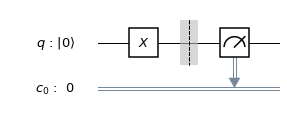

In [6]:
# single qubit circuit
qr1 = q.QuantumRegister(1, 'q')
cr1 = q.ClassicalRegister(1, 'c')

# preparation stage
prepare1 = q.QuantumCircuit(qr1, cr1)
prepare1.x(qr1[0])
prepare1.barrier()

# measurement stage
measure1 = q.QuantumCircuit(qr1, cr1)
measure1.barrier()
measure1.measure(qr1[0], cr1[0])

# idle stages
circuits_1 = []
for n in range(50):
    idle = q.QuantumCircuit(qr1, cr1)
    for _ in range(45 * n):
        idle.iden(qr1[0])
    circuits_1 += [prepare1 + idle + measure1]

circuits_1[0].draw(output='mpl')

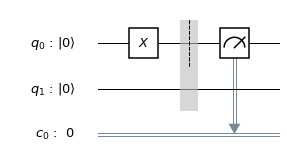

In [7]:
# double qubit circuit
qr2 = q.QuantumRegister(2, 'q')
cr2 = q.ClassicalRegister(1, 'c')

# preparation stage
prepare2 = q.QuantumCircuit(qr2, cr2)
prepare2.x(qr2[0])
prepare2.barrier()

# measurement stage
measure2 = q.QuantumCircuit(qr2, cr2)
measure2.barrier()
measure2.measure(qr2[0], cr2[0])

# idle stages
circuits_2 = []
for n in range(50):
    idle = q.QuantumCircuit(qr2, cr2)
    for _ in range(45 * n):
        idle.iden(qr2[0])
    circuits_2 += [prepare2 + idle + measure2]
    
circuits_2[0].draw(output='mpl')

Now let's compare the compiled versions of the two:

In [30]:
qobj_1 = q.compile(circuits_1[1], best, shots=1024)
qobj_2 = q.compile(circuits_2[1], best, shots=1024)

print('=== one qubit ===')
print(qobj_1.as_dict()['experiments'][0]['header']['compiled_circuit_qasm'])
print('=== two qubits ===')
print(qobj_2.as_dict()['experiments'][0]['header']['compiled_circuit_qasm'])

=== one qubit ===
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
u3(pi,0,pi) q[0];
barrier q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
barrier q[0];
measure q[0] -> c[0];

=== two qubits ===
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[1];
u3(pi,0,pi) q[0];
barrier q[0],q[1];
barrier q[0];
measure q[0] -> c[0];



And...therein lies the issue. When we have two qubits, Qiskit does some optimizations that it doesn't do when we have one qubit. We can turn this off by using the `skip_transpiler=True` option for `qiskit.compile`. We can verify that this does indeed work:

In [35]:
# okay, so skip_transpiler is 'deprecated'
qobj_2_good = q.compile(circuits_2[1], best, shots=1024, pass_manager=q.tools.compiler.PassManager())

print(qobj_2_good.as_dict()['experiments'][0]['header']['compiled_circuit_qasm'])

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[1];
x q[0];
barrier q[0],q[1];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
id q[0];
barrier q[0],q[1];
measure q[0] -> c[0];

